In [14]:
import math, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# BS Helpers
def bs_call_price(S, K, T, r, sigma):
    sqrtT = math.sqrt(T)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    N = Normal(0.0, 1.0)
    return S * N.cdf(d1) - K * torch.exp(-r * T) * N.cdf(d2)

def bs_delta(S, K, T, t, r, sigma):
    tau = max(T - t, 1e-12)
    sqrtTau = math.sqrt(tau)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrtTau)
    return Normal(0.0, 1.0).cdf(d1)

# MLP
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Deep BSDE class
class DeepBSDE_BS(nn.Module):
    def __init__(self, S0, S_max, S_min, r, sigma, K, T, N, hidden_dim, device):
        super().__init__()
        self.device = device
        self.S0 = torch.as_tensor(S0, device=self.device)
        self.r = torch.as_tensor(r, device=self.device)
        self.sigma = torch.as_tensor(sigma, device=self.device)
        self.K = torch.as_tensor(K, device=self.device)
        self.S_max, self.S_min = torch.as_tensor(S_max, device=self.device), torch.as_tensor(S_min, device=self.device)
        self.T, self.N = torch.as_tensor(T, device=self.device), torch.as_tensor(N, device=self.device)
        self.dt = T / N
        self.u0_net = MLP(in_dim=1, hidden_dim=hidden_dim).to(device)
        self.du0_net = MLP(in_dim=1, hidden_dim=hidden_dim).to(device)
        self.nets = nn.ModuleList([MLP(1, hidden_dim).to(device) for _ in range(N - 1)])

    def forward(self, dW_seq):
        batch = dW_seq.size(0)
        S_n = self.S_min + torch.rand(batch, 1, device=self.device) * (self.S_max - self.S_min)
        Y = self.u0_net(S_n)
        delta_0 = self.du0_net(S_n)
        for n in range(self.N):
            dW = dW_seq[:, n, :]
            delta = delta_0 if n == 0 else self.nets[n - 1](S_n)
            S_next = S_n + self.r * S_n * self.dt + self.sigma * S_n * dW
            Y = (1 + self.r * self.dt) * Y + self.sigma * S_n * delta * dW
            S_n = S_next
        payoff = torch.relu(S_n - self.K)
        term_loss = Y - payoff
        return term_loss

if __name__ == "__main__":
    S0, r, sigma, K = 100.0, 0.05, 0.2, 100.0
    T, N = 1.0, 100
    S_max, S_min = 140, 60
    path_num = 1024
    hidden_dim = 64
    lr = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DeepBSDE_BS(S0, S_max, S_min, r, sigma, K, T, N, hidden_dim, device).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    sqrt_dt = math.sqrt(model.dt)
    start_time = time.time()

    epochs = 1000
    dW = sqrt_dt * torch.randn(path_num, N, 1, device=device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        diff = model(dW)
        loss = criterion(diff, torch.zeros_like(diff))
        loss.backward()
        optimizer.step()
        if epoch == 0 or epoch % 50 == 49:
            print(f"Epoch [{epoch + 1:4d}/{epochs}]  Loss: {loss.item():.4e}")

    print(f"\nFinished in {time.time() - start_time:.2f} s")
    torch.save(model.state_dict(), f"BSbsde_model_delta_{epochs}_{lr}_{path_num}.pth")


Epoch [   1/1000]  Loss: 9.0292e+02
Epoch [  50/1000]  Loss: 3.0657e+02
Epoch [ 100/1000]  Loss: 1.8967e+02
Epoch [ 150/1000]  Loss: 1.4955e+02
Epoch [ 200/1000]  Loss: 7.1840e+01
Epoch [ 250/1000]  Loss: 4.0631e+01
Epoch [ 300/1000]  Loss: 1.7678e+01
Epoch [ 350/1000]  Loss: 7.1980e+00
Epoch [ 400/1000]  Loss: 3.0821e+00
Epoch [ 450/1000]  Loss: 1.4859e+00
Epoch [ 500/1000]  Loss: 8.4709e-01
Epoch [ 550/1000]  Loss: 6.8225e-01
Epoch [ 600/1000]  Loss: 1.0504e+00
Epoch [ 650/1000]  Loss: 9.7394e-01
Epoch [ 700/1000]  Loss: 1.9470e+00
Epoch [ 750/1000]  Loss: 7.7900e-01
Epoch [ 800/1000]  Loss: 6.1617e-01
Epoch [ 850/1000]  Loss: 5.9242e-01
Epoch [ 900/1000]  Loss: 8.5732e-01
Epoch [ 950/1000]  Loss: 7.3899e-01
Epoch [1000/1000]  Loss: 5.0264e-01

Finished in 130.50 s


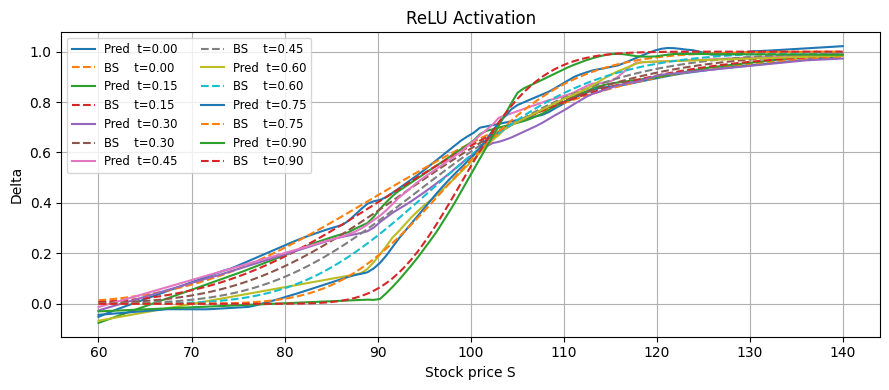

In [17]:
"""
Delta-comparison script for a trained DeepBSDE_BS network
--------------------------------------------------------
✓ 载入模型权重
✓ 逐个时间步计算网络 Delta
✓ 与 Black-Scholes 理论 Delta 对比
"""

import math, torch, numpy as np, matplotlib.pyplot as plt
from torch.distributions import Normal
import os, re

MODEL_PATH = "/content/BSbsde_model_delta_1000_0.001_1024.pth"
S0, r, sigma, K = 100.0, 0.05, 0.2, 100.0
T, N            = 1.0, 100
S_MAX, S_MIN    = 140, 60
HIDDEN_DIM      = 64
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TIME_IDX  = [0, 15, 30, 45, 60, 75, 90]
S_GRID    = torch.linspace(60, 140, 120).view(-1, 1).to(DEVICE)

def bs_delta_np(S_np, K, T, t, r, sigma):
    """返回 NumPy 数组，便于直接画图"""
    tau = np.maximum(T - t, 1e-12)
    d1  = (np.log(S_np / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return Normal(0, 1).cdf(torch.tensor(d1)).numpy()

class MLP(torch.nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)
        self.bn1, self.bn2 = torch.nn.BatchNorm1d(hidden_dim), torch.nn.BatchNorm1d(hidden_dim)
        self.act = torch.nn.ReLU()
    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.act(self.bn2(self.fc2(x)))
        return self.fc3(x)

class DeepBSDE_BS(torch.nn.Module):
    def __init__(self, S0, S_max, S_min, r, sigma, K, T, N, hidden_dim, device):
        super().__init__()
        self.device = device
        self.r, self.sigma, self.K = r, sigma, K
        self.dt   = T / N
        self.u0_net  = MLP(1, hidden_dim).to(device)
        self.du0_net = MLP(1, hidden_dim).to(device)
        self.nets    = torch.nn.ModuleList([MLP(1, hidden_dim).to(device) for _ in range(N - 1)])

net = DeepBSDE_BS(S0, S_MAX, S_MIN, r, sigma, K, T, N, HIDDEN_DIM, DEVICE).to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)
net.load_state_dict(state)
net.eval()

plt.figure(figsize=(9, 4))
for idx in TIME_IDX:
    t     = idx * (T / N)
    S_np  = S_GRID.squeeze().cpu().numpy()
    delta_bs = bs_delta_np(S_np, K, T, t, r, sigma)
    with torch.no_grad():
        if idx == 0:
            delta_pred = net.du0_net(S_GRID).squeeze().cpu().numpy()
        else:
            delta_pred = net.nets[idx - 1](S_GRID).squeeze().cpu().numpy()
    plt.plot(S_np, delta_pred,  "-",  label=f"Pred  t={t:.2f}")
    plt.plot(S_np, delta_bs,    "--", label=f"BS    t={t:.2f}")

plt.xlabel("Stock price S")
plt.ylabel("Delta")
plt.title(f"ReLU Activation")
plt.grid(True)
plt.legend(fontsize="small", ncol=2)
plt.tight_layout()
plt.show()
